In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from evaluate_paddlepaddle import evaluate
from sklearn.preprocessing import MinMaxScaler
from common.data_loader import *
from common.preprocessing import*

from os import path, environ
import matplotlib.pyplot as plt



In [2]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm
import seaborn as sns
from metrics import cond_loss
from tst import Transformer
from tst.loss import OZELoss
from tst.src.dataset import OzeDataset
from tst.src.utils import compute_loss
from tst.src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample
from livelossplot import PlotLosses
# # Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Transformer

In [3]:
BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 100
SEQ_LEN = 2



## load data

In [4]:
# Load dataset
full_data = pd.read_csv("data/wtbdata_245days.csv")
# train_data = pd.read_csv("data/train_data.csv")
submission = pd.read_csv("data/sample_submission.csv")
test_data = pd.read_csv("info/target.csv")
full_data = full_data.fillna(method = 'bfill')
# train_data = train_data.fillna(method = 'bfill')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


## preprocess

In [71]:
full_data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,23:10,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,-111.69,601.44
4727516,134,245,23:20,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,-72.67,673.79
4727517,134,245,23:30,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,-118.70,999.36
4727518,134,245,23:40,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,-58.12,1100.89


In [72]:
full_data.describe()

,TurbID,Day,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
count,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06,4.727520e+06
mean,6.750000e+01,1.230000e+02,5.057762e+00,4.800521e-01,4.110650e+01,2.740096e+01,1.880129e+02,2.674372e+01,2.671923e+01,2.671792e+01,-1.353280e+01,3.543701e+02
std,3.868139e+01,7.072483e+01,3.407044e+00,3.149749e+01,8.547043e+01,1.923756e+01,1.635187e+02,3.877513e+01,3.876421e+01,3.876229e+01,7.072137e+01,4.278090e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,-3.030460e+03,-2.730300e+02,-2.731700e+02,-8.848600e+02,-1.000000e+01,-1.000000e+01,-1.000000e+01,-6.249800e+02,-9.330000e+00
25%,3.400000e+01,6.200000e+01,2.250000e+00,-3.800000e+00,1.412000e+01,2.011000e+01,6.128000e+01,1.000000e-02,1.000000e-02,1.000000e-02,-3.898000e+01,-3.000000e-01
50%,6.750000e+01,1.230000e+02,4.370000e+00,-2.300000e-01,2.584000e+01,3.016000e+01,1.944000e+02,5.800000e-01,5.700000e-01,5.700000e-01,-3.000000e-01,1.814500e+02
75%,1.010000e+02,1.840000e+02,7.070000e+00,3.390000e+00,3.287000e+01,3.695000e+01,3.218500e+02,8.398000e+01,8.398000e+01,8.398000e+01,0.000000e+00,5.568900e+02
max,1.340000e+02,2.450000e+02,2.629000e+01,2.266950e+03,3.943300e+02,3.242100e+02,7.006200e+02,9.998000e+01,9.998000e+01,9.998000e+01,4.852000e+02,1.567020e+03


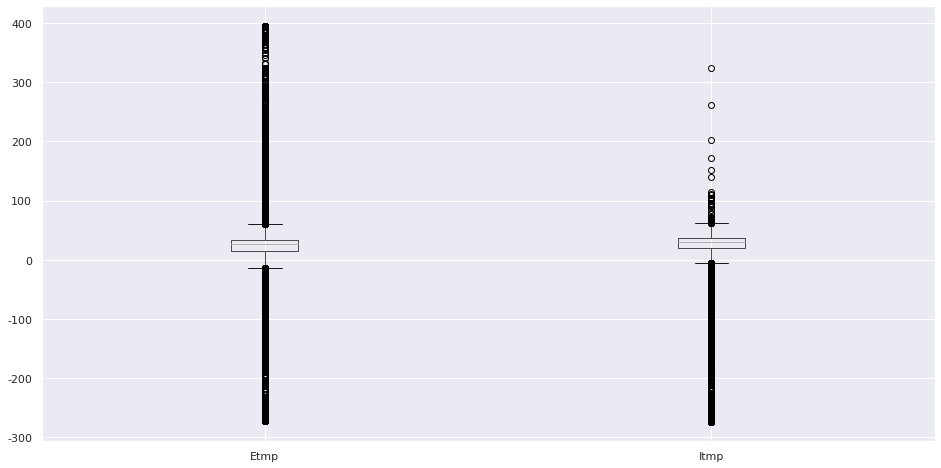

In [66]:
boxplot = full_data.boxplot(column=['Etmp', 'Itmp',])  

In [70]:
q1 = pd.DataFrame(full_data).quantile(0.25)
q3 = pd.DataFrame(full_data).quantile(0.75)
iqr = q3 - q1 #Interquartile range
fence_low = q1 - (1.5*iqr)
fence_high = q3 + (1.5*iqr)
print(iqr, fence_low, fence_high)

TurbID     67.00
Day       122.00
Wspd        4.82
Wdir        7.19
Etmp       18.75
Itmp       16.84
Ndir      260.57
Pab1       83.97
Pab2       83.97
Pab3       83.97
Prtv       38.98
Patv      557.19
dtype: float64 TurbID    -66.500
Day      -121.000
Wspd       -4.980
Wdir      -14.585
Etmp      -14.005
Itmp       -5.150
Ndir     -329.575
Pab1     -125.945
Pab2     -125.945
Pab3     -125.945
Prtv      -97.450
Patv     -836.085
dtype: float64 TurbID     201.500
Day        367.000
Wspd        14.300
Wdir        14.175
Etmp        60.995
Itmp        62.210
Ndir       712.705
Pab1       209.935
Pab2       209.935
Pab3       209.935
Prtv        58.470
Patv      1392.675
dtype: float64


In [ ]:
boxplot = full_data.boxplot(column=['Etmp', 'Itmp'])  

In [ ]:
full_data[full_data['Wdir'] > 180] = 180
full_data[full_data['Wdir'] < -180] = -180

In [ ]:
full_data[full_data['Wdir'] > 720] = 720
full_data[full_data['Wdir'] < -720] = -720

In [ ]:
full_data[full_data['Etmp'] < -20] = -20
full_data[full_data['Etmp'] > 50] = 50

In [ ]:
full_data[full_data['Itmp'] < -20] = -20
full_data[full_data['Itmp'] > 50] = 50

In [61]:
full_data[full_data['Pab1'] < 0] = 0
full_data[full_data['Pab1'] > 90] = 90
full_data[full_data['Pab2'] < 0] = 0
full_data[full_data['Pab2'] > 90] = 90
full_data[full_data['Pab3'] < 0] = 0
full_data[full_data['Pab3'] > 90] = 90

In [49]:
full_data['Ndir'].max()

700.62

In [7]:
# Preprocessing
full_data = preprocess(full_data)

In [8]:
data = full_data.copy()

## feature selecting

In [73]:
features = ['TurbID','Tmstamp','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'WspdX', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
data = data[features]

In [74]:
data

,TurbID,Tmstamp,Day,RPM,Bspd1,Bspd3,Bspd2,WspdX,Wspd,Wspd_cube,P_max,Pab1,Pab2,Pab3,TSR1,TSR2,TSR3,Prtv,Patv
0,1,0.000000,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
1,1,0.166667,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
2,1,0.333333,1,16.322087,16.322087,16.322087,16.322087,6.265462,6.27,245.957079,0.900427,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.24,509.76
3,1,0.500000,1,16.723314,16.723314,16.723314,16.723314,6.419479,6.42,264.544863,0.966892,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.26,542.53
4,1,0.666667,1,16.279842,16.279842,16.279842,16.279842,6.249246,6.25,244.052275,0.892196,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,23.166667,245,15.931622,15.931622,15.931622,15.931622,7.780700,7.79,471.038039,1.944747,6.03,6.03,6.03,2.047582,2.047582,2.047582,-111.69,601.44
4727516,134,23.333333,245,16.616593,16.616593,16.616593,16.616593,8.036353,8.06,519.011538,2.151395,5.81,5.81,5.81,2.067678,2.067678,2.067678,-72.67,673.79
4727517,134,23.500000,245,21.388748,21.388748,21.388748,21.388748,8.073603,8.08,526.262273,2.170929,0.68,0.68,0.68,2.649220,2.649220,2.649220,-118.70,999.36
4727518,134,23.666667,245,23.216175,23.216175,23.216175,23.216175,8.459175,8.46,605.318689,2.491649,0.02,0.02,0.02,2.744496,2.744496,2.744496,-58.12,1100.89


## make dataset

In [75]:
train_data = data[data['Day']<201]

In [76]:
train_data = generate_full_timestamp(train_data, drop = True)

In [77]:
train_data.drop(['Time_in_day'],axis = 1, inplace = True)
train_data

,TurbID,RPM,Bspd1,Bspd3,Bspd2,WspdX,Wspd,Wspd_cube,P_max,Pab1,Pab2,Pab3,TSR1,TSR2,TSR3,Prtv,Patv,Time
0,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66,1
1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66,2
2,1,16.322087,16.322087,16.322087,16.322087,6.265462,6.27,245.957079,0.900427,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.24,509.76,3
3,1,16.723314,16.723314,16.723314,16.723314,6.419479,6.42,264.544863,0.966892,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.26,542.53,4
4,1,16.279842,16.279842,16.279842,16.279842,6.249246,6.25,244.052275,0.892196,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.23,509.36,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721035,134,13.300998,13.300998,13.300998,13.300998,4.843796,4.86,113.646913,0.455178,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.13,308.65,28796
4721036,134,12.217265,12.217265,12.217265,12.217265,4.449136,4.46,88.069787,0.352134,0.01,0.01,0.01,2.745986,2.745986,2.745986,-93.64,221.60,28797
4721037,134,11.615510,11.615510,11.615510,11.615510,4.229996,4.23,75.686746,0.300476,0.01,0.01,0.01,2.745986,2.745986,2.745986,-111.20,220.60,28798
4721038,134,11.904266,11.904266,11.904266,11.904266,4.335151,4.36,81.472834,0.329171,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.04,222.15,28799


In [78]:
day = 144
hour = 6
ten_minute = 1
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(train_data, in_seq_len=SEQ_LEN*144, out_seq_len=SEQ_LEN*144, stride=day, shuffle=True, test_size=0.2)

100%|██████████| 134/134 [00:20<00:00,  6.53it/s]


Train data(X, y)     : (21038, 288, 16) (21038, 288, 16)
Validation data(X, y): (5360, 288, 16) (5360, 288, 16)
Test data(X)         : (134, 288, 16)


In [79]:
train_data

,TurbID,RPM,Bspd1,Bspd3,Bspd2,WspdX,Wspd,Wspd_cube,P_max,Pab1,Pab2,Pab3,TSR1,TSR2,TSR3,Prtv,Patv,Time
0,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66,1
1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66,2
2,1,16.322087,16.322087,16.322087,16.322087,6.265462,6.27,245.957079,0.900427,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.24,509.76,3
3,1,16.723314,16.723314,16.723314,16.723314,6.419479,6.42,264.544863,0.966892,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.26,542.53,4
4,1,16.279842,16.279842,16.279842,16.279842,6.249246,6.25,244.052275,0.892196,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.23,509.36,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4721035,134,13.300998,13.300998,13.300998,13.300998,4.843796,4.86,113.646913,0.455178,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.13,308.65,28796
4721036,134,12.217265,12.217265,12.217265,12.217265,4.449136,4.46,88.069787,0.352134,0.01,0.01,0.01,2.745986,2.745986,2.745986,-93.64,221.60,28797
4721037,134,11.615510,11.615510,11.615510,11.615510,4.229996,4.23,75.686746,0.300476,0.01,0.01,0.01,2.745986,2.745986,2.745986,-111.20,220.60,28798
4721038,134,11.904266,11.904266,11.904266,11.904266,4.335151,4.36,81.472834,0.329171,0.01,0.01,0.01,2.745986,2.745986,2.745986,-108.04,222.15,28799


In [89]:
scaler = MinMaxScaler()
scaler.fit(train_data.drop(['TurbID', 'Time'], axis = 1))
train_x_scaled = scaler.transform(train_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
train_y_scaled = scaler.transform(train_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_x_scaled = scaler.transform(val_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
val_y_scaled = scaler.transform(val_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_x_scaled = scaler.transform(test_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
print("Train data(X, y):", train_x_scaled.shape, train_y_scaled.shape)
print("Validation data(X, y):", val_x_scaled.shape, val_y_scaled.shape)
print("Test data(X):", test_x_scaled.shape)

Train data(X, y): (21038, 288, 16) (21038, 288, 16)
Validation data(X, y): (5360, 288, 16) (5360, 288, 16)
Test data(X): (134, 288, 16)


In [102]:

# Model parameters
d_model = 256 # Lattent dim
q = 64 # Query size
v = 64 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = None # Attention window size
dropout = 0.1 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = train_x.shape[-1] # From dataset
d_output = train_y.shape[-1] # From dataset



In [103]:
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss(reduction='mean')

In [104]:
net.modules

<bound method Module.modules of Transformer(
  (layers_encoding): ModuleList(
    (0): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=256, out_features=512, bias=True)
        (_W_k): Linear(in_features=256, out_features=512, bias=True)
        (_W_v): Linear(in_features=256, out_features=512, bias=True)
        (_W_o): Linear(in_features=512, out_features=256, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=256, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=256, bias=True)
      )
      (_layerNorm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.1, inplace=False)
    )
    (1): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=256, out_features=512, bias=True)
        (_W_k): Linear(in_features=256,

In [105]:
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        sample =(text, label)
        return sample

In [110]:
dataset_train = Dataset(train_x, train_y)
dataset_val = Dataset(val_x, val_y)
dataset_test = Dataset(test_x, test_x)

In [111]:
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )
dataloader_val = DataLoader(dataset_val,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )
dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )

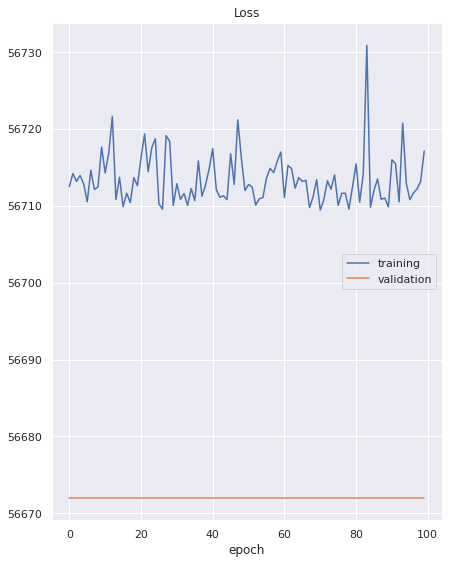

Loss
	training         	 (min: 56709.446, max: 56730.881, cur: 56717.121)
	validation       	 (min: 56672.035, max: 56672.035, cur: 56672.035)
model exported to saved_models/model_2022_07_15__162012.pth with loss 56672.035156


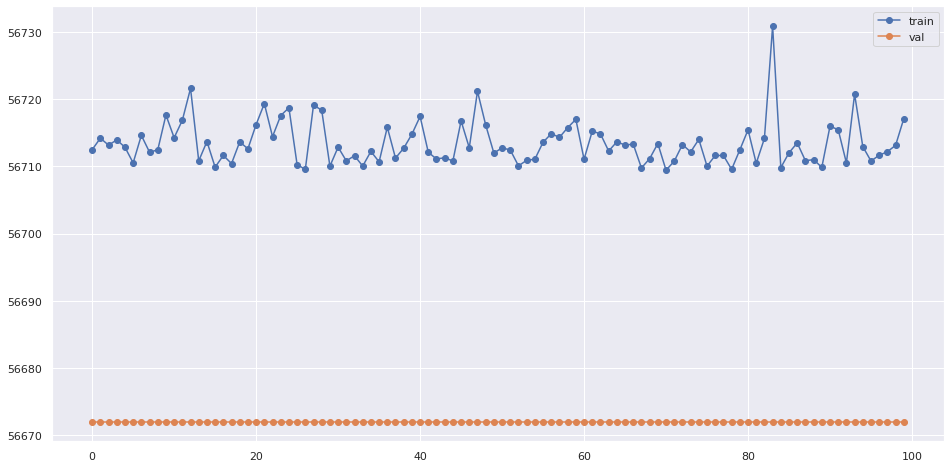

In [115]:
current_time = datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")
model_save_path = f'saved_models/model_{current_time}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
liveloss = PlotLosses()
for idx_epoch in range(EPOCHS):
    running_loss = 0
    logs = {}
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
    
#     logs['train_loss'] =train_loss
#     logs['val_loss'] =val_loss
#     liveloss.update(logs)
    liveloss.update({ 'loss': train_loss, 'val_loss':val_loss})
    liveloss.send()
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")


In [116]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 288, 16))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 17/17 [00:00<00:00, 18.83it/s]


In [117]:
predictions.shape

(134, 288, 16)

In [118]:
pred = predictions.reshape(-1,predictions.shape[2])

In [119]:
pred.shape

(38592, 16)

In [120]:
pred_inversed = scaler.inverse_transform(pred)

In [121]:
submission['Patv'] =pred_inversed[:,-1]
now = datetime.datetime.now()
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))

Accuracy:  -5.0184%

 	 RMSE: 1179.4981748503924, MAE: 1116.3109880428565

 --- Overall Score --- 
	1147.9045814466244


# Model parameters
d_model = 512 # Lattent dim
q = 64 # Query size
v = 64 # Value size
h = 8 # Number of heads
N = 6 # Number of encoder and decoder to stack
attention_size = None # Attention window size
dropout = 0.1 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

Accuracy:  58.4989%

 	 RMSE: 392.9678370258425, MAE: 337.41877478975755

 --- Overall Score --- 
	365.19330590780004